## Introduction

In [1]:
# Importing necessary Libraries
import os, sys, glob
from keras import backend as K
import numpy as np
from shutil import copyfile
%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


### Preparing the data

In [2]:
homeDir = os.getcwd()
dataHome = homeDir + "/data/"
dataDir = homeDir + "/data/"
train_path = dataDir + "train/"
valid_path = dataDir + "valid/"
model_path = dataDir + "models/"
test_path = dataHome + "test/"
results_path = dataDir + "results/"

Creation of the Training data and validation data is already done before. Hence we continue for now.

## Using VGG16

In [3]:
%cd $homeDir
from utils import *
from vgg16 import Vgg16
from vgg16bn import Vgg16BN ## Vgg16 with batchnorm

/home/ubuntu/KaggleCompetitions/Fisheries


In [32]:
vgg = Vgg16()

In [21]:
#Set constants. You can experiment with no_of_epochs to improve the model. 
# You can reduce the batch_size depending on the memory contraints of gpu
batch_size=64
no_of_epochs=1

In [6]:
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)

Found 3342 images belonging to 8 classes.
Found 435 images belonging to 8 classes.


We took the Vgg16 model, now we remove the last layer which was tailored for imagenet 1000 categories, we remove that layer and have just 8 outputs corresponding to our competition and retrain only last layer keeping ever other layer cosntant

In [33]:
vgg.model.pop() #Remove the final layer
for layer in vgg.model.layers:
    layer.trainable=False # Set all other layers to untrainable

In [34]:
#Adding a new dense layer wiht only 8 outputs and softmax acitvation as it is the output layer
vgg.model.add(Dense(8, activation='softmax')) 

#### Adam

In [35]:
vgg.model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [36]:
vgg.model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=5,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample, verbose=2)

Epoch 1/5
98s - loss: 1.9664 - acc: 0.5063 - val_loss: 0.9211 - val_acc: 0.6828
Epoch 2/5
96s - loss: 1.3955 - acc: 0.6008 - val_loss: 0.6199 - val_acc: 0.8092
Epoch 3/5
93s - loss: 1.1082 - acc: 0.6795 - val_loss: 0.5280 - val_acc: 0.8322
Epoch 4/5
94s - loss: 0.9594 - acc: 0.7035 - val_loss: 0.5149 - val_acc: 0.8437
Epoch 5/5
94s - loss: 0.8073 - acc: 0.7427 - val_loss: 0.4212 - val_acc: 0.8644


In [37]:
vgg.model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [38]:
vgg.model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=5,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample, verbose=2)

Epoch 1/5
98s - loss: 0.7425 - acc: 0.7582 - val_loss: 0.3853 - val_acc: 0.8690
Epoch 2/5
94s - loss: 0.7149 - acc: 0.7612 - val_loss: 0.3167 - val_acc: 0.9080
Epoch 3/5
94s - loss: 0.6848 - acc: 0.7762 - val_loss: 0.3734 - val_acc: 0.8874
Epoch 4/5
94s - loss: 0.7026 - acc: 0.7753 - val_loss: 0.3419 - val_acc: 0.8874
Epoch 5/5
93s - loss: 0.6666 - acc: 0.7825 - val_loss: 0.3258 - val_acc: 0.8897


#### RmsProp

In [13]:
vgg.model.compile(optimizer=RMSprop(lr=0.001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [14]:
vgg.model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=2,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/2
3342/3342 [==============================] - 99s - loss: 1.0228 - acc: 0.7232 - val_loss: 0.4901 - val_acc: 0.8575

In [15]:
vgg.model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=2,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample, verbose=2)

Epoch 1/2
98s - loss: 0.7782 - acc: 0.7735 - val_loss: 0.4261 - val_acc: 0.8713
Epoch 2/2
95s - loss: 0.7876 - acc: 0.7528 - val_loss: 0.3802 - val_acc: 0.8690


In [16]:
vgg.model.compile(optimizer=RMSprop(lr=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [17]:
vgg.model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=2,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/2
3342/3342 [==============================] - 98s - loss: 0.5693 - acc: 0.8133 - val_loss: 0.3015 - val_acc: 0.8828

#### SGD with nesterov momentum

In [29]:
vgg.model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [30]:
vgg.model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=2,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample,verbose=2)

Epoch 1/2
100s - loss: 6.0805 - acc: 0.5093 - val_loss: 5.8268 - val_acc: 0.5333
Epoch 2/2
95s - loss: 5.5288 - acc: 0.5775 - val_loss: 5.8641 - val_acc: 0.5931


In [31]:
vgg.model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=8,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample,verbose=2)

Epoch 1/8
96s - loss: 5.5712 - acc: 0.5907 - val_loss: 5.0857 - val_acc: 0.6506
Epoch 2/8
94s - loss: 5.3960 - acc: 0.6212 - val_loss: 5.5227 - val_acc: 0.6322
Epoch 3/8
93s - loss: 5.5381 - acc: 0.6164 - val_loss: 5.2810 - val_acc: 0.6506
Epoch 4/8
93s - loss: 5.7645 - acc: 0.6062 - val_loss: 4.9550 - val_acc: 0.6621
Epoch 5/8
94s - loss: 5.5838 - acc: 0.6152 - val_loss: 5.7435 - val_acc: 0.6253
Epoch 6/8
94s - loss: 5.5577 - acc: 0.6224 - val_loss: 4.8882 - val_acc: 0.6736
Epoch 7/8
94s - loss: 5.5089 - acc: 0.6305 - val_loss: 5.5104 - val_acc: 0.6391
Epoch 8/8
94s - loss: 5.6376 - acc: 0.6206 - val_loss: 5.2586 - val_acc: 0.6690


Not able to converge wiht SGD, not sure whats the problem, but will have to reserach more on this.

### Finetuning the dense layers

## Predictions

### vgg model predictions

In [39]:
tbatches, preds = vgg.test(test_path, batch_size = 64)

Found 1000 images belonging to 1 classes.


In [40]:
preds[0:5]

array([[  2.6367e-03,   6.7098e-06,   1.4913e-05,   6.0218e-10,   9.9681e-01,   2.9119e-05,
          2.7831e-05,   4.7664e-04],
       [  1.8090e-01,   7.7866e-01,   5.6856e-05,   6.8923e-05,   3.8884e-05,   2.5873e-02,
          5.1767e-05,   1.4348e-02],
       [  9.8846e-01,   1.3204e-03,   2.6803e-05,   4.7814e-04,   3.0878e-04,   3.2292e-03,
          1.7717e-04,   6.0022e-03],
       [  9.6197e-01,   7.1899e-03,   3.4422e-04,   2.3000e-05,   1.6439e-04,   1.9155e-02,
          8.1331e-06,   1.1143e-02],
       [  6.5238e-01,   6.6284e-04,   8.8717e-05,   1.3378e-06,   8.5714e-03,   3.4663e-02,
          1.3060e-02,   2.9058e-01]], dtype=float32)

In [41]:
filenames = tbatches.filenames
filenames[0:5]

['unnames/img_00005.jpg',
 'unnames/img_00007.jpg',
 'unnames/img_00009.jpg',
 'unnames/img_00018.jpg',
 'unnames/img_00027.jpg']

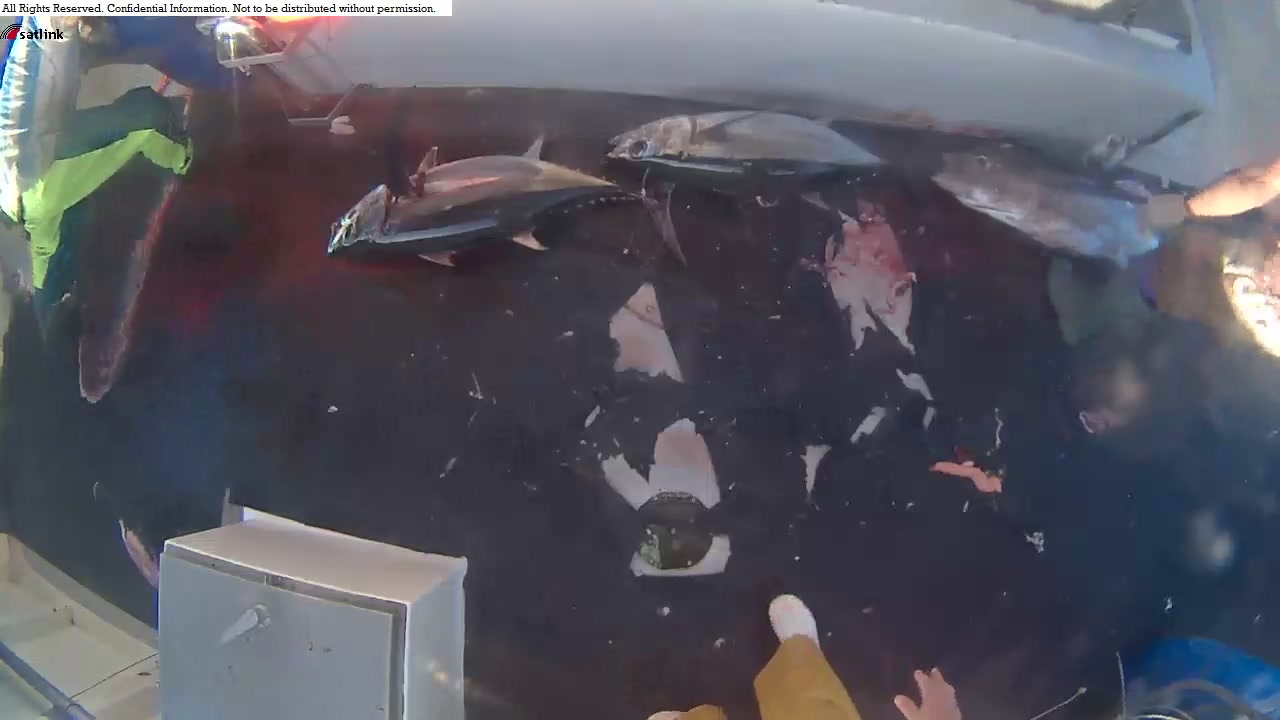

In [42]:
from PIL import Image
Image.open(test_path + filenames[2])

In [ ]:
preds = np.clip(preds,0.01,0.99)
files = [s.split('/')[-1] for s in filenames]
import pandas as pd
df = pd.DataFrame(preds, columns=['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'])
df.insert(0,'image', files)
subFile = results_path + 'fineTuneLastlayer_Adam_0_32.csv'
df.to_csv(subFile, index=False)